In [26]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.formula.api as smf

mpl.rcParams["font.family"] = "NanumGothic"
mpl.rcParams["axes.unicode_minus"] = False
dep = '노인인구_기관수_비율'

In [27]:
df = pd.read_csv("../../data/elderly/pre_processing_data/rate_groupby_region_year.csv")
df.head()

,시도명,년도,노인인구_기관수_비율
0,강원특별자치도,2008,0.005100
1,강원특별자치도,2009,0.005194
2,강원특별자치도,2010,0.005223
3,강원특별자치도,2011,0.005346
4,강원특별자치도,2012,0.005325


In [28]:
## 회귀 모형 추정

## 전국 회귀모형 추정

national_model = smf.ols("노인인구_기관수_비율 ~ 년도", data=df).fit()
beta_N = national_model.params["년도"]
se_N = national_model.bse["년도"]

national_row = pd.DataFrame({
    "시도명": ["전국"],
    "beta_r": [beta_N],
    "se_r": [se_N]
})

## 시도별 회귀 모형 (17개 각각)

regions = df["시도명"].unique()

results = []

for region in regions:
    df_r = df[df["시도명"] == region]

    model_r = smf.ols("노인인구_기관수_비율 ~ 년도", data=df_r).fit()

    beta_r = model_r.params["년도"]
    se_r = model_r.bse["년도"]

    results.append([region, beta_r, se_r])

results_df = pd.DataFrame(results, columns=["시도명", "beta_r", "se_r"])

## 전국 + 시도별 테이블 결합

full_slope_table = pd.concat([national_row, results_df], axis=0).reset_index(drop=True)

full_slope_table

,시도명,beta_r,se_r
0,전국,0.000032,0.000016
1,강원특별자치도,-0.000010,0.000006
2,경기도,-0.000017,0.000007
3,경상남도,-0.000004,0.000008
4,경상북도,0.000007,0.000005
5,광주광역시,0.000097,0.000012
6,대구광역시,0.000018,0.000006
7,대전광역시,-0.000033,0.000006
8,부산광역시,0.000067,0.000003
9,서울특별시,0.000130,0.000006


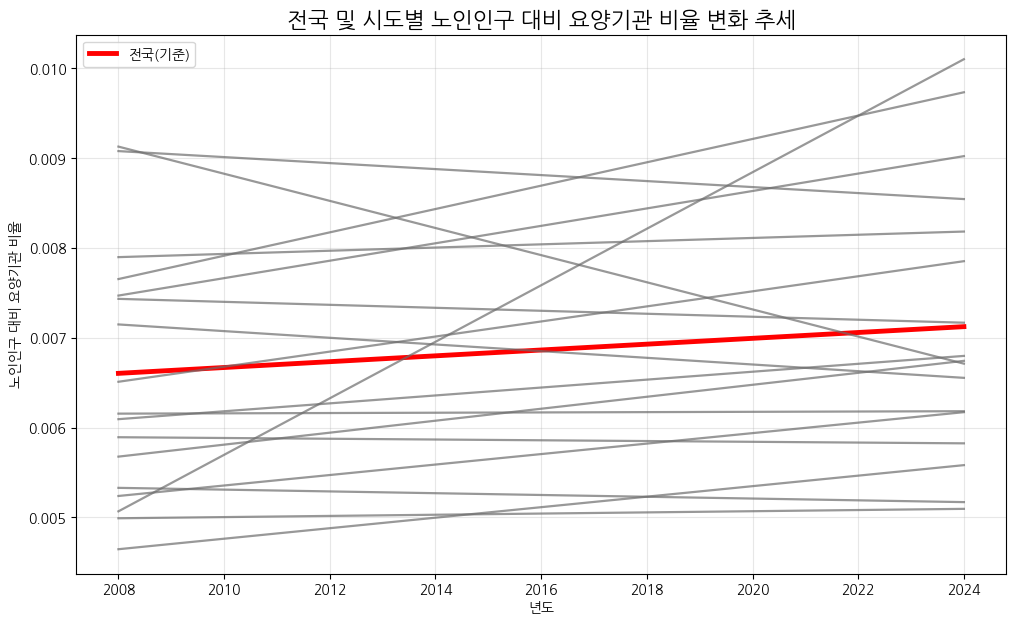

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 7))

years = np.arange(df["년도"].min(), df["년도"].max() + 1)

# 전국 회귀모형
national_model = smf.ols("노인인구_기관수_비율 ~ 년도", data=df).fit()
beta_N = national_model.params["년도"]
intercept_N = national_model.params["Intercept"]
national_line = intercept_N + beta_N * years

# 1) 전국선 (강조)
plt.plot(
    years,
    national_line,
    color="red",
    linewidth=3.5,
    label="전국(기준)"
)

# 2) 시도별 선 (조금 더 진하게)
regions = df["시도명"].unique()

for region in regions:
    df_r = df[df["시도명"] == region]

    model_r = smf.ols("노인인구_기관수_비율 ~ 년도", data=df_r).fit()
    beta_r = model_r.params["년도"]
    intercept_r = model_r.params["Intercept"]
    region_line = intercept_r + beta_r * years

    plt.plot(
        years,
        region_line,
        color="#6c6c6c",  # 진한 회색
        linewidth=1.6,
        alpha=0.7
    )

plt.title("전국 및 시도별 노인인구 대비 요양기관 비율 변화 추세", fontsize=16)
plt.xlabel("년도")
plt.ylabel("노인인구 대비 요양기관 비율")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [31]:
## Z-Score 검정

def slope_test(beta_r, se_r, beta_N, se_N):
    z = (beta_r - beta_N) / np.sqrt(se_r**2 + se_N**2)
    p = 2 * (1 - norm.cdf(abs(z)))  # 양측검정
    return z, p

z_list = []
p_list = []

for i in range(len(results_df)):
    beta_r = results_df.loc[i, "beta_r"]
    se_r = results_df.loc[i, "se_r"]
    
    z, p = slope_test(beta_r, se_r, beta_N, se_N)
    
    z_list.append(z)
    p_list.append(p)

results_df["z-stat"] = z_list
results_df["p-value"] = p_list
results_df["p-value < 0.05"] = results_df["p-value"] < 0.05

results_df

,시도명,beta_r,se_r,z-stat,p-value,p-value < 0.05
0,강원특별자치도,-0.000010,0.000006,-2.509398,1.209370e-02,True
1,경기도,-0.000017,0.000007,-2.783976,5.369700e-03,True
2,경상남도,-0.000004,0.000008,-2.054440,3.993308e-02,True
3,경상북도,0.000007,0.000005,-1.558529,1.191079e-01,False
4,광주광역시,0.000097,0.000012,3.267031,1.086817e-03,True
5,대구광역시,0.000018,0.000006,-0.859220,3.902192e-01,False
6,대전광역시,-0.000033,0.000006,-3.823150,1.317574e-04,True
7,부산광역시,0.000067,0.000003,2.112905,3.460893e-02,True
8,서울특별시,0.000130,0.000006,5.770191,7.918151e-09,True
9,세종특별자치시,0.000315,0.000049,5.467657,4.560244e-08,True


In [33]:
## 시각화를 위한 테이블 생성 + 전국 행 추가
national_row = pd.DataFrame({
    "시도명": ["전국"],
    "beta_r": [beta_N],
    "se_r": [se_N],
    "z-stat": [np.nan],
    "p-value": [np.nan],
    "p-value < 0.05": [np.nan]
})

results_df_with_national = pd.concat([national_row, results_df], axis=0).reset_index(drop=True)

results_df_with_national

,시도명,beta_r,se_r,z-stat,p-value,p-value < 0.05
0,전국,0.000032,0.000016,NaN,NaN,NaN
1,강원특별자치도,-0.000010,0.000006,-2.509398,1.209370e-02,1.0
2,경기도,-0.000017,0.000007,-2.783976,5.369700e-03,1.0
3,경상남도,-0.000004,0.000008,-2.054440,3.993308e-02,1.0
4,경상북도,0.000007,0.000005,-1.558529,1.191079e-01,0.0
5,광주광역시,0.000097,0.000012,3.267031,1.086817e-03,1.0
6,대구광역시,0.000018,0.000006,-0.859220,3.902192e-01,0.0
7,대전광역시,-0.000033,0.000006,-3.823150,1.317574e-04,1.0
8,부산광역시,0.000067,0.000003,2.112905,3.460893e-02,1.0
9,서울특별시,0.000130,0.000006,5.770191,7.918151e-09,1.0


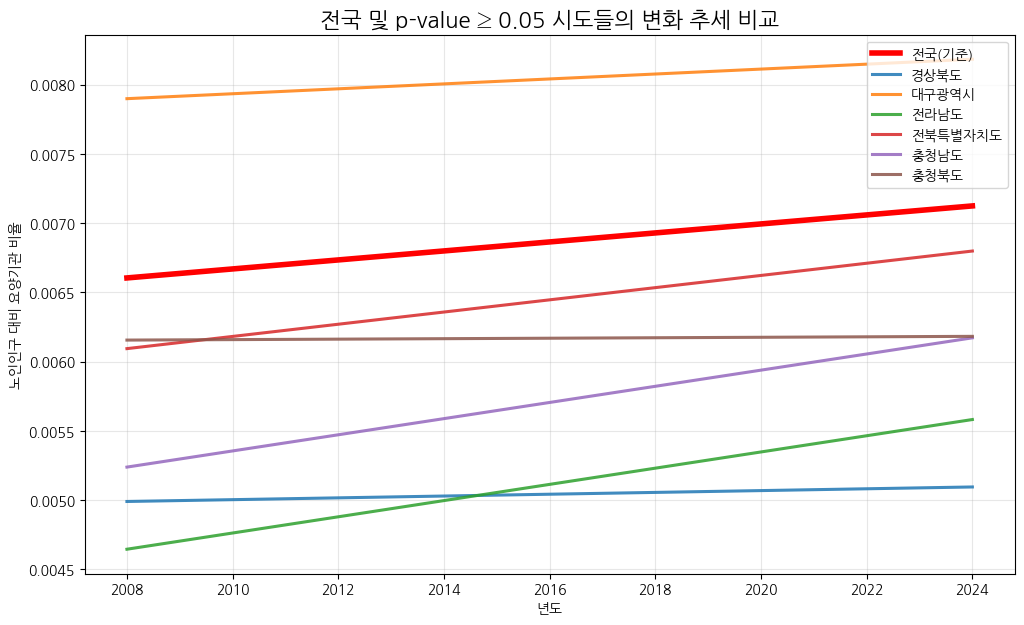

In [36]:
# ----------------------------------------
# 1) 전국 + p-value>=0.05 시도들 필터링
# ----------------------------------------
plot_df = results_df_with_national[
    (results_df_with_national["시도명"] == "전국") |
    (results_df_with_national["p-value"] >= 0.05)
]

plot_df = plot_df.reset_index(drop=True)

# ----------------------------------------
# 2) 기본 설정
# ----------------------------------------
plt.figure(figsize=(12, 7))

years = np.arange(df["년도"].min(), df["년도"].max() + 1)

# 색상 팔레트 (전국 제외)
palette = sns.color_palette("tab10", n_colors=len(plot_df) - 1)

color_idx = 0

# ----------------------------------------
# 3) 그래프 그리기
# ----------------------------------------
for i, row in plot_df.iterrows():
    region = row["시도명"]
    beta = row["beta_r"]
    se = row["se_r"]

    # 회귀모형 불러오기 (전국 vs 시도별)
    if region == "전국":
        model_r = smf.ols("노인인구_기관수_비율 ~ 년도", data=df).fit()
    else:
        df_r = df[df["시도명"] == region]
        model_r = smf.ols("노인인구_기관수_비율 ~ 년도", data=df_r).fit()

    intercept_r = model_r.params["Intercept"]
    line = intercept_r + beta * years

    # 전국선 강조
    if region == "전국":
        plt.plot(
            years, line,
            color="red", linewidth=4,
            label="전국(기준)", alpha=1.0
        )
    else:
        plt.plot(
            years, line,
            color=palette[color_idx],
            linewidth=2.2, alpha=0.85,
            label=region
        )
        color_idx += 1

# ----------------------------------------
# 4) 그래프 옵션
# ----------------------------------------
plt.title("전국 및 p-value ≥ 0.05 시도들의 변화 추세 비교", fontsize=16)
plt.xlabel("년도")
plt.ylabel("노인인구 대비 요양기관 비율")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

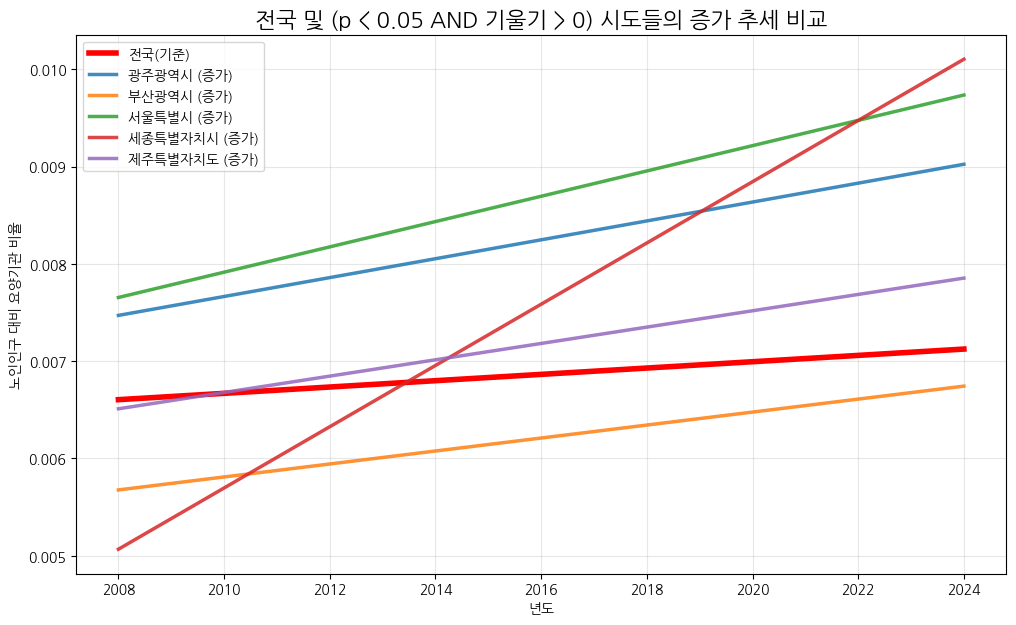

In [38]:

# ----------------------------------------
# 1) 전국 + p-value<0.05 AND 기울기>0 시도 필터링
# ----------------------------------------
plot_df = results_df_with_national[
    (results_df_with_national["시도명"] == "전국") |
    ((results_df_with_national["p-value"] < 0.05) &
     (results_df_with_national["beta_r"] > 0))
]

plot_df = plot_df.reset_index(drop=True)

# ----------------------------------------
# 2) 기본 설정
# ----------------------------------------
plt.figure(figsize=(12, 7))
years = np.arange(df["년도"].min(), df["년도"].max() + 1)

palette = sns.color_palette("tab10", n_colors=len(plot_df) - 1)
color_idx = 0

# ----------------------------------------
# 3) 시각화
# ----------------------------------------
for i, row in plot_df.iterrows():
    region = row["시도명"]
    beta = row["beta_r"]

    # 회귀모형 적합 (전국 vs 시도)
    if region == "전국":
        model_r = smf.ols("노인인구_기관수_비율 ~ 년도", data=df).fit()
    else:
        model_r = smf.ols("노인인구_기관수_비율 ~ 년도",
                          data=df[df["시도명"] == region]).fit()

    intercept_r = model_r.params["Intercept"]
    line = intercept_r + beta * years

    # 전국선 강조
    if region == "전국":
        plt.plot(
            years, line,
            color="red", linewidth=4,
            alpha=1.0, label="전국(기준)"
        )
    # 유의미한 증가 시도들 색 적용
    else:
        plt.plot(
            years, line,
            color=palette[color_idx],
            linewidth=2.5,
            alpha=0.85,
            label=f"{region} (증가)"
        )
        color_idx += 1

# ----------------------------------------
# 4) 그래프 옵션
# ----------------------------------------
plt.title("전국 및 (p < 0.05 AND 기울기 > 0) 시도들의 증가 추세 비교", fontsize=16)
plt.xlabel("년도")
plt.ylabel("노인인구 대비 요양기관 비율")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


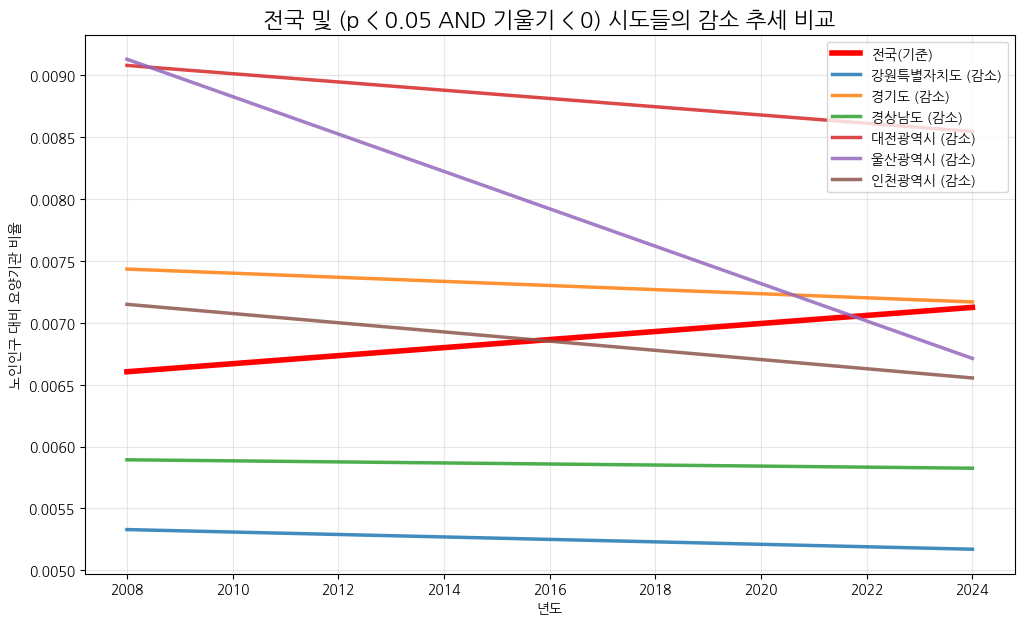

In [39]:

# ---------------------------------------------------------
# 1) 전국 + p<0.05 AND beta_r<0 시도 필터링
# ---------------------------------------------------------
plot_df = results_df_with_national[
    (results_df_with_national["시도명"] == "전국") |
    ((results_df_with_national["p-value"] < 0.05) &
     (results_df_with_national["beta_r"] < 0))
]

plot_df = plot_df.reset_index(drop=True)

# ---------------------------------------------------------
# 2) 기본 설정
# ---------------------------------------------------------
plt.figure(figsize=(12, 7))
years = np.arange(df["년도"].min(), df["년도"].max() + 1)

palette = sns.color_palette("tab10", n_colors=len(plot_df) - 1)
color_idx = 0

# ---------------------------------------------------------
# 3) 시각화
# ---------------------------------------------------------
for i, row in plot_df.iterrows():
    region = row["시도명"]
    beta = row["beta_r"]

    # 회귀모형 적합
    if region == "전국":
        model_r = smf.ols("노인인구_기관수_비율 ~ 년도", data=df).fit()
    else:
        df_r = df[df["시도명"] == region]
        model_r = smf.ols("노인인구_기관수_비율 ~ 년도", data=df_r).fit()

    intercept_r = model_r.params["Intercept"]
    line = intercept_r + beta * years

    # ------------------------
    # 전국선(강조)
    # ------------------------
    if region == "전국":
        plt.plot(
            years, line,
            color="red",
            linewidth=4,
            alpha=1.0,
            label="전국(기준)"
        )
    # ------------------------
    # 감소하는(음의 기울기) 유의미한 시도들
    # ------------------------
    else:
        plt.plot(
            years, line,
            color=palette[color_idx],
            linewidth=2.5,
            alpha=0.85,
            label=f"{region} (감소)"
        )
        color_idx += 1

# ---------------------------------------------------------
# 4) 그래프 옵션
# ---------------------------------------------------------
plt.title("전국 및 (p < 0.05 AND 기울기 < 0) 시도들의 감소 추세 비교", fontsize=16)
plt.xlabel("년도")
plt.ylabel("노인인구 대비 요양기관 비율")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


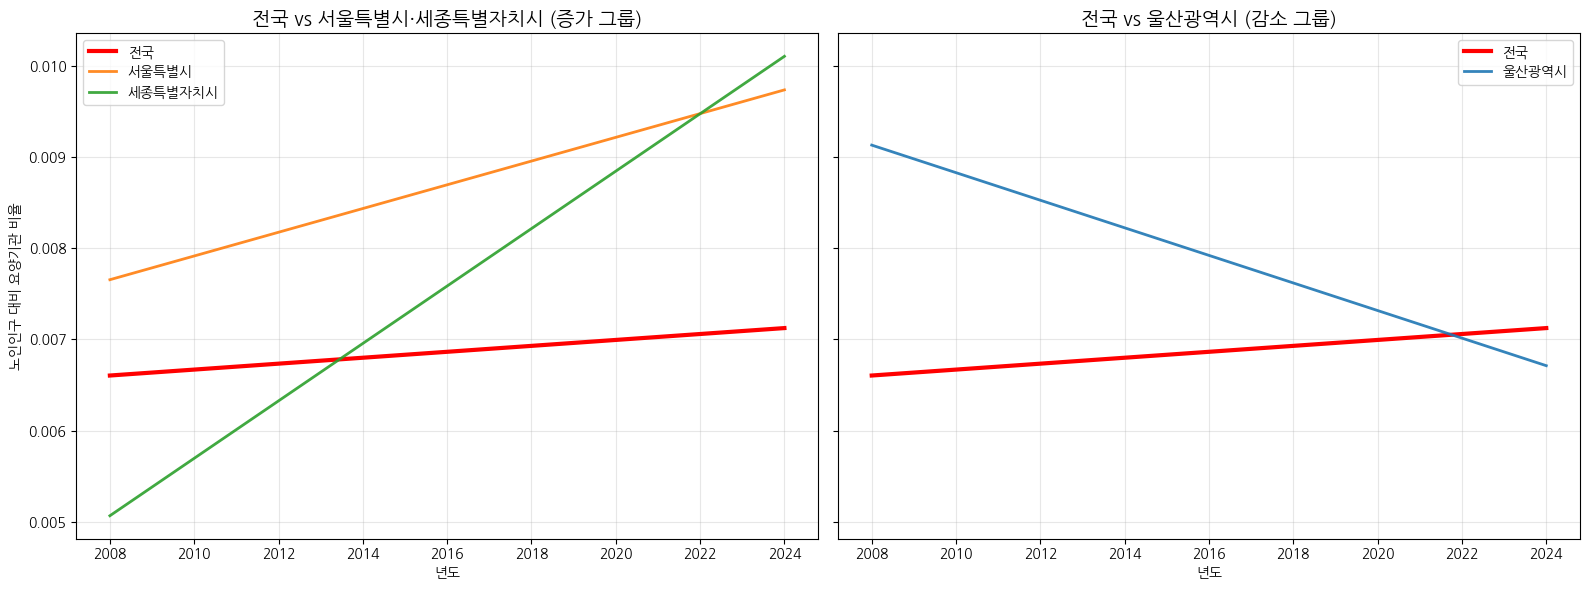

In [41]:
years = np.arange(df["년도"].min(), df["년도"].max() + 1)

# 색상 설정
color_map = {
    "전국": "red",
    "서울특별시": "#ff7f0e",      # 주황
    "세종특별자치시": "#2ca02c",  # 초록
    "울산광역시": "#1f77b4"       # 파랑
}

# -------------------------------
# subplot 준비
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# -------------------------------
# 1. 왼쪽: 전국 + 서울 + 세종
# -------------------------------
left_regions = ["전국", "서울특별시", "세종특별자치시"]

for region in left_regions:
    if region == "전국":
        model = smf.ols("노인인구_기관수_비율 ~ 년도", data=df).fit()
    else:
        model = smf.ols("노인인구_기관수_비율 ~ 년도",
                        data=df[df["시도명"] == region]).fit()

    beta = model.params["년도"]
    intercept = model.params["Intercept"]
    line = intercept + beta * years
    
    axes[0].plot(
        years, line,
        label=region,
        linewidth=3 if region == "전국" else 2,
        color=color_map[region],
        alpha=1.0 if region == "전국" else 0.9
    )

axes[0].set_title("전국 vs 서울특별시·세종특별자치시 (증가 그룹)", fontsize=14)
axes[0].set_xlabel("년도")
axes[0].set_ylabel("노인인구 대비 요양기관 비율")
axes[0].grid(alpha=0.3)
axes[0].legend()

# -------------------------------
# 2. 오른쪽: 전국 + 울산
# -------------------------------
right_regions = ["전국", "울산광역시"]

for region in right_regions:
    if region == "전국":
        model = smf.ols("노인인구_기관수_비율 ~ 년도", data=df).fit()
    else:
        model = smf.ols("노인인구_기관수_비율 ~ 년도",
                        data=df[df["시도명"] == region]).fit()

    beta = model.params["년도"]
    intercept = model.params["Intercept"]
    line = intercept + beta * years
    
    axes[1].plot(
        years, line,
        label=region,
        linewidth=3 if region == "전국" else 2,
        color=color_map[region],
        alpha=1.0 if region == "전국" else 0.9
    )

axes[1].set_title("전국 vs 울산광역시 (감소 그룹)", fontsize=14)
axes[1].set_xlabel("년도")
axes[1].grid(alpha=0.3)
axes[1].legend()

# -------------------------------
# show
# -------------------------------
plt.tight_layout()
plt.show()

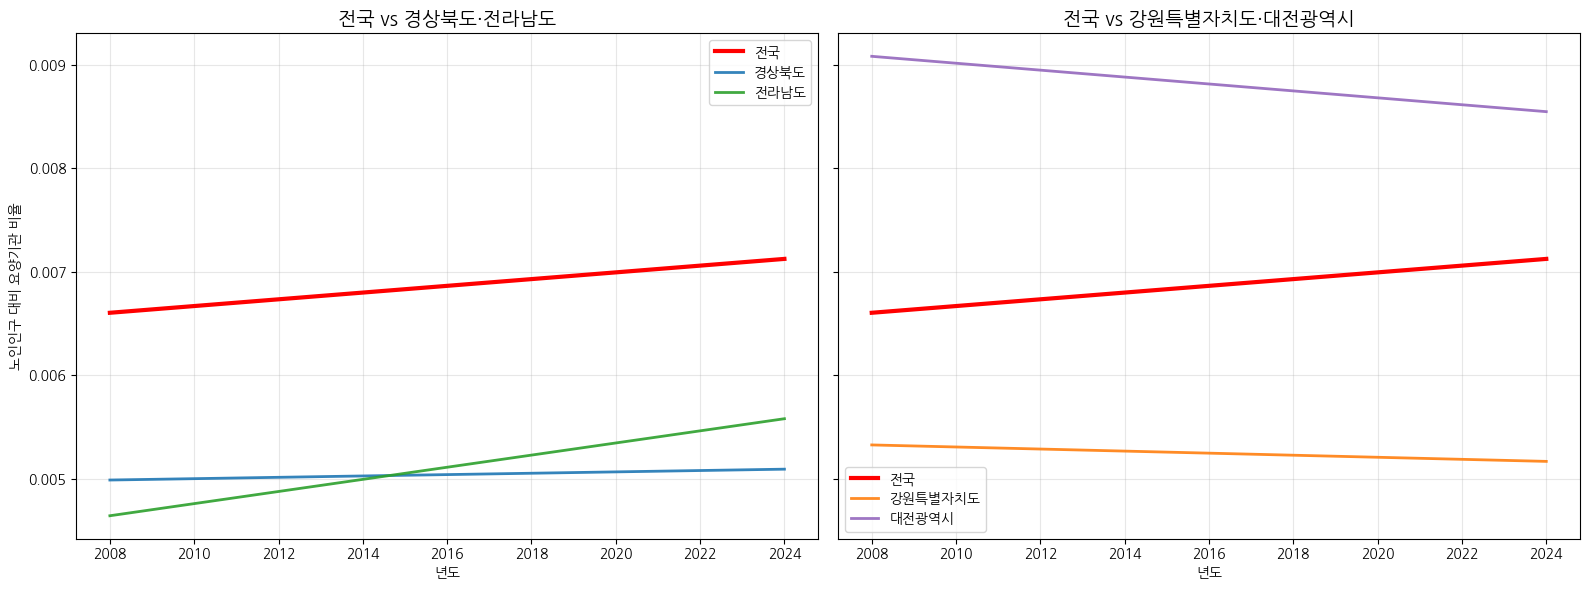

In [43]:

# -------------------------------
# 기본 설정
# -------------------------------
years = np.arange(df["년도"].min(), df["년도"].max() + 1)

# 색상 설정
color_map = {
    "전국": "red",
    "경상북도": "#1f77b4",        # 파랑
    "전라남도": "#2ca02c",        # 초록
    "강원특별자치도": "#ff7f0e",  # 주황
    "대전광역시": "#9467bd"       # 보라
}

# -------------------------------
# subplot 준비
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# ======================================================
# 1. 왼쪽: 전국 + 경상북도 + 전라남도
# ======================================================
left_regions = ["전국", "경상북도", "전라남도"]

for region in left_regions:
    if region == "전국":
        model = smf.ols("노인인구_기관수_비율 ~ 년도", data=df).fit()
    else:
        model = smf.ols("노인인구_기관수_비율 ~ 년도",
                        data=df[df["시도명"] == region]).fit()

    beta = model.params["년도"]
    intercept = model.params["Intercept"]
    line = intercept + beta * years

    axes[0].plot(
        years, line,
        label=region,
        linewidth=3 if region == "전국" else 2,
        color=color_map[region],
        alpha=1.0 if region == "전국" else 0.9
    )

axes[0].set_title("전국 vs 경상북도·전라남도", fontsize=14)
axes[0].set_xlabel("년도")
axes[0].set_ylabel("노인인구 대비 요양기관 비율")
axes[0].grid(alpha=0.3)
axes[0].legend()

# ======================================================
# 2. 오른쪽: 전국 + 강원특별자치도 + 대전광역시
# ======================================================
right_regions = ["전국", "강원특별자치도", "대전광역시"]

for region in right_regions:
    if region == "전국":
        model = smf.ols("노인인구_기관수_비율 ~ 년도", data=df).fit()
    else:
        model = smf.ols("노인인구_기관수_비율 ~ 년도",
                        data=df[df["시도명"] == region]).fit()

    beta = model.params["년도"]
    intercept = model.params["Intercept"]
    line = intercept + beta * years

    axes[1].plot(
        years, line,
        label=region,
        linewidth=3 if region == "전국" else 2,
        color=color_map[region],
        alpha=1.0 if region == "전국" else 0.9
    )

axes[1].set_title("전국 vs 강원특별자치도·대전광역시", fontsize=14)
axes[1].set_xlabel("년도")
axes[1].grid(alpha=0.3)
axes[1].legend()

# -------------------------------
# show
# -------------------------------
plt.tight_layout()
plt.show()
